# Transition Path

In this notebook, I solve and simulate the housing model along a **transition path** stemming from an interest rate shock

In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy import optimize
from consav import linear_interp

# load the DurableConsumptionModel module
from HousingModel import HousingModelClass

# Set the number of threads in numba
nb.set_num_threads(4)

# Smoother
# from scipy.signal import savgol_filter

This is to individually test each step in the relaxation algorithm for any troubleshooting

# Find Equilibrium Along a Transition Path

I apply a relaxation algorithm where I use a ghost run along the path as the benchmark to update equilibrium prices

In [28]:
# Define the model
model = HousingModelClass(name='example_negm',par={'solmethod':'negm', 'do_print':False})

# # Solve and simulate
model.precompile_numba()
model.solve()
model.simulate()

Ghost run - simulate path without an interest rate drop

In [31]:
# No drop in interest rates
model.par.R_drop = 0.01

# Solve and simulate along the path
model.solve_path()
model.simulate_path()

Check if everything looks reasonable

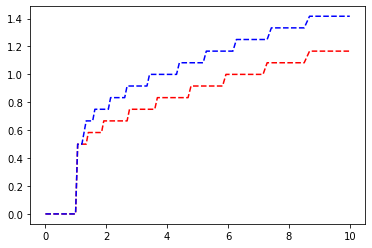

In [36]:
plt.plot(model.par.grid_m, model.sol.d_adj[0,0,1,:], linestyle = '--', color = 'red', linewidth = '1.5', label = r'$y=y_2$')
plt.plot(model.par.grid_m, model.sol_path.d_adj[0,0,1,:], linestyle = '--', color = 'blue', linewidth = '1.5', label = r'$y=y_2$')

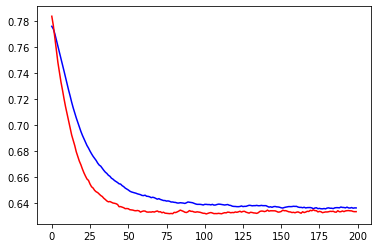

In [32]:
# Define aggregates
h_ss = np.mean(model.sim.d, axis=1)
h_path = np.mean(model.sim_path.d, axis=1)

# Plot results
plt.plot(h_ss, color ='blue')
plt.plot(h_path, color = 'red')
plt.show()

Looks fine!

In [7]:
# Define ghost run path
H_ghost = np.mean(model.sim_path.d, axis=1)

## Apply relaxation algorithm 

In [19]:
# Initialize model and solve initial steady state
model_path = HousingModelClass(name='example_negm',par={'solmethod':'negm', 'do_print':False})
model_path.precompile_numba()
model_path.solve()
model_path.simulate() # simulate initial ss

Check how the partial eq. impulse response looks

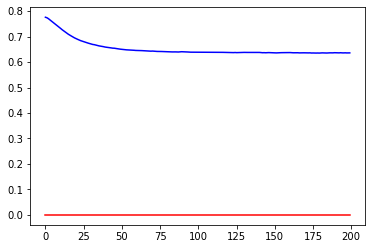

In [20]:
h_ss = np.mean(model_path.sim.d, axis=1)
h_path = np.mean(model_path.sim_path.d, axis=1)

# Plot results
plt.plot(h_ss, color ='blue')
plt.plot(h_path, color = 'red')
plt.show()

In [ ]:
# a. allocate
path_ph = np.zeros(model_path.par.path_T + model_path.par.T)

# b. setting - 0.9999
nu = 0.3 # relaxation parameter
max_iter = 1000 # maximum number of iterations

# # c. Set path of prices
path_ph[:] = model_path.par.ph
model_path.par.path_ph = path_ph

# d. iterate
it = 0
for _ in range(max_iter):

    # ii. solve and simulate
    model_path.solve_path()
    model_path.simulate_path()

    # iii. Implied aggregate housing demand
    H = np.mean(model_path.sim_path.d, axis=1)
    
    # iv. difference
    max_abs_diff = np.max(np.abs(H[:-2] - H_ghost[:-2]))
    # if it%10 == 0: print(f'{it:4d}: {max_abs_diff:.8f}')
    if max_abs_diff < 10e-4: break # test different values of this threshold

    # v. update
    path_ph[:model_path.par.path_T] = path_ph[:model_path.par.path_T] + nu*(H - H_ghost)
    path_ph[model_path.par.path_T:] = path_ph[model_path.par.path_T-3]
    
    model_path.par.path_ph = path_ph    
    
    # vi.  increment
    it += 1
    if it > max_iter: raise Exception('too many iterations')    
    
    print(str(it)+'th iteration: dif = '+str(max_abs_diff))

1th iteration: dif = 0.1418260947371669
2th iteration: dif = 0.13243283315236187
3th iteration: dif = 0.12212838656020208
4th iteration: dif = 0.11821019559033263
5th iteration: dif = 0.11366747023778467
6th iteration: dif = 0.10673614315021951
7th iteration: dif = 0.09797770343895496
8th iteration: dif = 0.09451340652164109
9th iteration: dif = 0.09322716996233293
10th iteration: dif = 0.08879031747431865
11th iteration: dif = 0.08330403191228053
12th iteration: dif = 0.0780991869713078
13th iteration: dif = 0.07256578768279787
14th iteration: dif = 0.06928129849104248
15th iteration: dif = 0.06864517291324668
16th iteration: dif = 0.06393287087365362
17th iteration: dif = 0.06245174645949236
18th iteration: dif = 0.05907028735435904
19th iteration: dif = 0.05587682147785278
20th iteration: dif = 0.05138276977407463
21th iteration: dif = 0.04775979314212753
22th iteration: dif = 0.04697060272183884
23th iteration: dif = 0.04446088980684326
24th iteration: dif = 0.04268109813676679
25t

## Plot the Impulse Responses

Define path of aggregates, so that it starts 10 periods before the shock

In [22]:
p_path = np.zeros(10+model_path.par.path_T)
p_path[0:10] = model_path.par.ph
p_path[10:] = model_path.par.path_ph[0:model_path.par.path_T]

c_path = np.zeros(10+model_path.par.path_T)
c_path[0:10] = np.mean(model_path.sim.c, axis=1)[-10:]
c_path[10:] = np.mean(model_path.sim_path.c, axis=1)

m_path = np.zeros(10+model_path.par.path_T)
m_path[0:10] = np.mean(model_path.sim.m, axis=1)[-10:]
m_path[10:] = np.mean(model_path.sim_path.m, axis=1)

t_axis = range(-10,200) # Time from shock

Equilibrium housing price

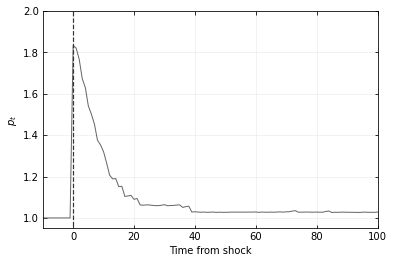

In [28]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, p_path, color = '0.4', linestyle='-', linewidth=1,  label = 'Demand',zorder=2)
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,100)
# ax.set_ylim(6.98,7.53)
ax.set_ylim(0.95,2.0)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'$p_t$')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

# plt.savefig('../../tex/figs/IRF_ph.pdf')

Non-durable consumption

In [ ]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, c_path, color = 'blue', linestyle='-', linewidth=1,  label = 'Demand',zorder=2)
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,100)
ax.set_ylim(1.095,1.122)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'$c^\mathrm{agg}_t$')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/IRF_c.pdf')

Cash on hand

In [ ]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, m_path, color = 'red', linestyle='-', linewidth=1,  label = 'Demand',zorder=2)
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,100)
ax.set_ylim(1.84,2.11)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'$m^\mathrm{agg}_t$')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

plt.savefig('../../tex/figs/IRF_m.pdf')

# Test the transition path with avancebeskatning

In [2]:
# Define the model
model = HousingModelClass(name='example_negm',par={'solmethod':'negm', 'do_print':False})

# Solve and simulate
model.precompile_numba()

Generate ghost path

In [3]:
model.solve()
model.simulate()

In [4]:
# No drop in interest rates
model.par.R_drop = 0.0

# Solve and simulate along the path
model.solve_path()
model.simulate_path()

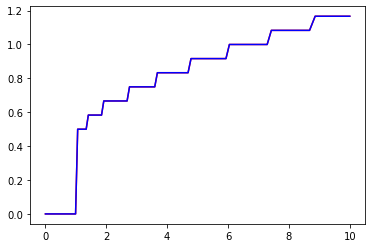

In [5]:
plt.plot(model.par.grid_m, model.sol_path.d_adj[0,17,1,:], linestyle = '-', color = 'red', linewidth = '1.5')
plt.plot(model.par.grid_m, model.sol_path.d_adj[0,5,1,:], linestyle = '-', color = 'blue', linewidth = '1.5')

# plt.plot(model.par.grid_m, model.sol.d_adj[0,17,1,:], linestyle = '--', color = 'red', linewidth = '1.5')
# plt.plot(model.par.grid_m, model.sol.d_adj[0,5,1,:], linestyle = '--', color = 'blue', linewidth = '1.5')

In [6]:
H_ghost = np.mean(model.sim_path.d, axis=1)

Run Relaxation algo

In [7]:
# Initialize model and solve initial steady state
taug = 0.02
model_path = HousingModelClass(name='example_negm',par={'solmethod':'negm', 'taug':taug, 'do_print':False})
model_path.precompile_numba()
model_path.solve()
model_path.simulate() # simulate initial ss

In [8]:
model_path.solve_path()
model_path.simulate_path()

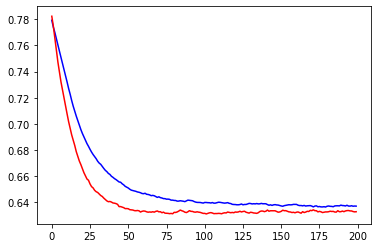

In [9]:
h_ss = np.mean(model_path.sim.d, axis=1)
h_path = np.mean(model_path.sim_path.d, axis=1)

# Plot results
plt.plot(h_ss, color ='blue')
plt.plot(h_path, color = 'red')
plt.show()

Same result as withou gains tax; should be in partial eq.

In [10]:
# a. allocate
path_ph = np.zeros(model_path.par.path_T + model_path.par.T)

# b. setting - 0.9999
nu = .03 # relaxation parameter
max_iter = 1000 # maximum number of iterations

# # c. Set path of prices
path_ph[:] = model_path.par.ph
model_path.par.path_ph = path_ph

# d. iterate
it = 0
for _ in range(max_iter):

    # ii. solve and simulate
    model_path.solve_path()
    model_path.simulate_path()

    # iii. Implied aggregate housing demand
    H = np.mean(model_path.sim_path.d, axis=1)
    
    # iv. difference
    max_abs_diff = np.max(np.abs(H[:-2] - H_ghost[:-2]))
    # if it%10 == 0: print(f'{it:4d}: {max_abs_diff:.8f}')
    if max_abs_diff < 10e-4: break # test different values of this threshold

    # v. update
    path_ph[:model_path.par.path_T] = path_ph[:model_path.par.path_T] + nu*(H - H_ghost)
    path_ph[model_path.par.path_T:] = path_ph[model_path.par.path_T-3]
    
    model_path.par.path_ph = path_ph    
    
    # vi.  increment
    it += 1
    if it > max_iter: raise Exception('too many iterations')    
    
    print(str(it)+'th iteration: dif = '+str(max_abs_diff))

1th iteration: dif = 0.14044084393107947
2th iteration: dif = 0.10012017727243061
3th iteration: dif = 0.060681889547105294
4th iteration: dif = 0.04630992926985589
5th iteration: dif = 0.03721827968009872
6th iteration: dif = 0.03173516877657956
7th iteration: dif = 0.027278314772014145
8th iteration: dif = 0.023906284090648433
9th iteration: dif = 0.02135836919231804
10th iteration: dif = 0.01898625648188823
11th iteration: dif = 0.01743513394557794
12th iteration: dif = 0.016256313416645907
13th iteration: dif = 0.015238890056878285
14th iteration: dif = 0.014370262256642508
15th iteration: dif = 0.013550031445309307
16th iteration: dif = 0.013031180322903846
17th iteration: dif = 0.012473386776171491
18th iteration: dif = 0.011868318361534236
19th iteration: dif = 0.011911569787037335
20th iteration: dif = 0.011517522838223382
21th iteration: dif = 0.011210767554525991
22th iteration: dif = 0.010706923284271364
23th iteration: dif = 0.010292687370912268
24th iteration: dif = 0.0099

Traceback (most recent call last):
  File "C:\Users\madsh\OneDrive - University of Copenhagen\Desktop\Thesis\code\MA_thesis\HousingModel.py", line 528, in solve_path
    last_period.solve(t,sol_path,par,ph)
KeyboardInterrupt


KeyboardInterrupt: 

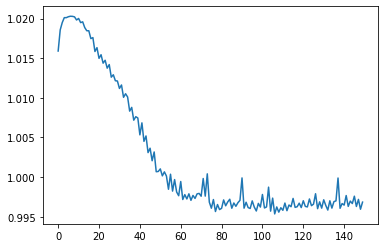

In [11]:
plt.plot(path_ph[0:150])